In [1]:
from libdatasets import *
import librun
import libstop
from importlib import reload
from libadversarial import uncertainty_stop
from libstop import rank_stop_conds
from dotenv import load_dotenv; load_dotenv();
import libactive; reload(libactive)
import matplotlib.pyplot as plt
import math

In [2]:
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        #("anuran", wrap(anuran, None)),
        #("avila", wrap(avila, None)),
        #("covertype", wrap(covertype, None)),
        #("rcv1", wrap(rcv1, None)),
        #("sensorless", wrap(sensorless, None)),
        ("spamassassin", wrap(spamassassin, None)),
        #("splice", wrap(splice, None)),
        #("swarm", wrap(swarm, None)),
        #("smartphone", wrap(smartphone, None))
    ],
    "dataset_mutators": {
        "none": (lambda *x, **kwargs: x),
    },
    "methods": [
        ("uncertainty", partial(uncertainty_stop, n_instances=10)),
    ],
    "models": [
        "svm-linear"
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 10,
        "test_size": 0.5,
        "n_runs": 10,
        "ret_classifiers": True,
        "ensure_y": True,
        "stop_info": True,
        "aggregate": False,
        "stop_function": ("len1000", lambda learner: learner.y_training.shape[0] >= 1000),
        "pool_subsample": 1000
    }
}

In [3]:
results = librun.run(matrix, force_cache=True, fragment_run_start=0, fragment_run_end=1)
results_plots = [result[0] for result in results]
classifiers = [result[1] for result in results]
classifiers = [clf for clf in classifiers]

['C:\\Users\\Zac\\AppData\\Local\\pypoetry\\Cache\\virtualenvs\\research-KKf5lz0r-py3.8\\lib\\site-packages\\ipykernel_launcher.py', '-f', 'C:\\Users\\Zac\\AppData\\Roaming\\jupyter\\runtime\\kernel-5ea283f6-b3df-40b1-998b-92b15be629be.json']


Experiment:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
reload(libstop); from libstop import *
def acc_wrapper(d=0, **kwargs):
    x, diffs = first_acc(**kwargs)
    if d > 0:
        grad = np.array([np.nan, *no_ahead_tvregdiff(diffs, 1, 1e-1, plotflag=False, diagflag=False)])
    
        if d == 1:
            return grad
        
        return np.array([np.nan, np.nan, np.nan, *no_ahead_tvregdiff(grad[3:], 1, 1e-1, plotflag=False, diagflag=False)])
    return [np.nan] +diffs
metrics = ['accuracy_score', acc_wrapper, partial(acc_wrapper, d=1), partial(acc_wrapper, d=2)] # 
names = ['Accuracy', 'First Accuracy', '1st Derivative', '2nd Derivative']

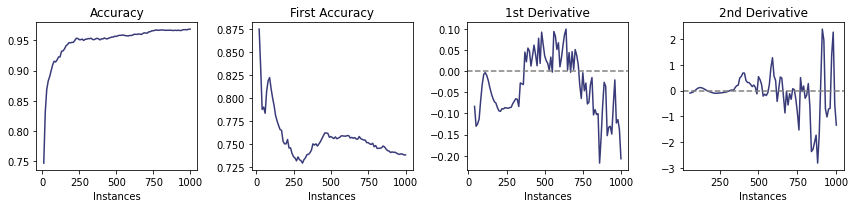

In [11]:
fig, axes = plt.subplots(1, 4, figsize=(12,3))
results = results_plots[0][1]
conf = results_plots[0][0]
cm = plt.cm.get_cmap('tab20b')
for j, (metric, ax, name) in enumerate(zip(metrics, axes.flatten(), names)):
    # Get unlabelled pool
    X, y = getattr(libdatasets, conf.dataset_name)(None)
    unlabelled_pools = []
    y_oracles = []
    # WARN: This is not the same as the job numbers! Unfortunately they're not easily accessible
    for i in range(len(results)):
        _, X_unlabelled, _, Y_oracle, _, _ = active_split(
            X, y, labeled_size=conf.meta['labelled_size'], test_size=conf.meta['test_size'], random_state=check_random_state(i), ensure_y=conf.meta['ensure_y']
        )
        unlabelled_pools.append(X_unlabelled)
        y_oracles.append(Y_oracle)
    
    if isinstance(metric, str):
        values = np.array([results[i][metric] for i in range(len(results))])
        ax.set_title(name)
    else:
        values = np.array([metric(**results[i], classifiers=classifiers[0][i], X_unlabelled=unlabelled_pools[i], Y_oracle=y_oracles[i]) for i in range(len(results))])
        ax.set_title(name)
    ax.plot(results[0].x, np.mean(values, axis=0), label='Metric', color=cm.colors[0])
    
    if j > 1:
        ax.axhline(0, ls='--', color='grey')
    
    ax.set_xlabel("Instances")
fig.tight_layout()

In [12]:
fig.savefig('figures/method.png')